# Building a NIRISS Instrument
We want to build a framework that can support dLux `optics`, `source`, `detector` and `observation` objects.

In [2]:
import webbpsf
import dLux as dl
from dLux.utils import deg_to_rad as d2r
import jax.numpy as np
from matplotlib import pyplot as plt
from jax import config

from optics import NIRISSOptics
from sources import NIRISSSource
from observations import NIRISSFilters
from detector_layers import ApplyBFE, DistortionFromSiaf
from instruments import NIRISS

config.update("jax_enable_x64", True)
plt.rcParams["image.origin"] = 'lower'

In [3]:
# creating NIRISS object
webbpsfobj = webbpsf.NIRISS()
webbpsfobj.calc_psf()  # calculating fits files
NIS_CEN_aperture = webbpsfobj.siaf.apertures['NIS_CEN']

osys = NIRISSOptics()
src = dl.PointSource(**dict(np.load('filter_configs/F480M.npz')))
obs = NIRISSFilters()
det = dl.LayeredDetector([
    dl.detector_layers.RotateDetector(-d2r(getattr(NIS_CEN_aperture, "V3IdlYAngle")), order=3),  # Rotates PSF by half a degree
    DistortionFromSiaf(aperture=NIS_CEN_aperture),  # Wavefront sphere to wavefront plane
    dl.IntegerDownsample(kernel_size=4),  # Downsample to detector pixel scale
    # ApplyBFE(1e-6),  # Apply BFE
])
instrument = dl.Instrument(optics=osys, sources=src, detector=det, observation=obs)

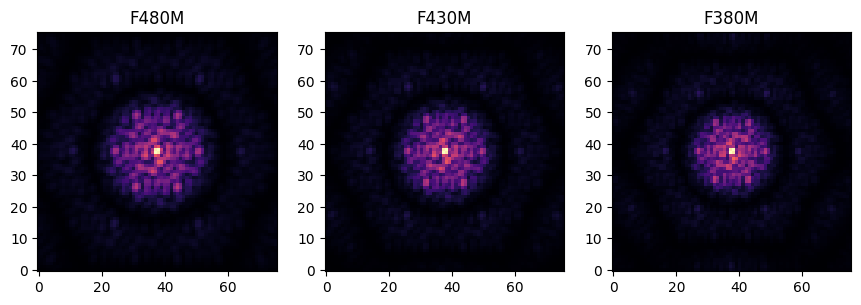

In [6]:
psfs = instrument.observe()

fig, ax = plt.subplots(1, 3, figsize=(10.5, 4))
for i, psf in enumerate(psfs):
    ax[i].imshow(psf**.5, cmap='magma')
    ax[i].set(title=f'{obs.filters[i]}')
plt.show()

## WebbPSF
Let's double check that they match WebbPSF.

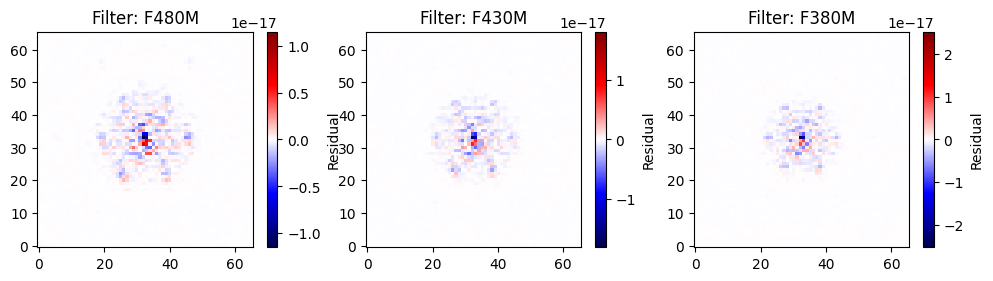

In [23]:
webbpsfobj.pupil_mask = 'MASK_NRM'
n = 5  # edge pixels
fig, ax = plt.subplots(1, 3, figsize=(12, 2.8))

for i, filt in enumerate(obs.filters):
    webbpsfobj.filter = filt
    webbpsfpsfs = webbpsfobj.calc_psf()

    residuals = (webbpsfpsfs[3].data - psfs[i])[n:-n, n:-n]
    bound = np.array([-residuals.min(), residuals.max()]).max()
    c=ax[i].imshow(residuals,
                   cmap='seismic',
                   vmin=-bound,
                   vmax=bound,
                   )

    ax[i].set(title=f'Filter: {obs.filters[i]}')
    fig.colorbar(c, label='Residual')

slay